# Sieci neuronowe i Deep Learning
# Temat 5: Moduł torch.nn w bibliotece PyTorch

## Zadanie 5.1

Wykorzystując moduł `torch.nn`, zbudować sieć MLP dla zadania
klasyfikacji odręcznie pisanych cyfr na podstawie zbioru danych MNIST, rozważanego w ramach zajęć nr 3 (patrz notebook do wykładu nr 3).

- W pierwszej kolejności odtworzyć sieć implementowaną od podstaw jako przykład w ramach zajęć nr 3 i porównać otrzymane wyniki.

- Następnie rozważyć różne modyfikacje tej sieci z wykorzystaniem możliwości, które daje moduł `torch.nn` (rozważyć inną liczbę i budowę warstw ukrytych, przetestować różne funkcje aktywacji oraz inne algorytmy optymalizacyjne z modułu `torch.optim`). Porównać otrzymane wyniki.

Wszystkie sieci w ramach tego zadania skonstruować na podstawie tych samych danych uczących, walidacyjnych i testowych – utworzonych w analogiczny sposób jak w notebooku z wykładu 3.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
print('PyTorch version:', torch.__version__)

np.set_printoptions(precision=3)

PyTorch version: 2.2.1


In [2]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [3]:
# Funckja fetch_openml (z scikit-learn) pobiera zbiór danych MNIST 
# z OpenML (https://www.openml.org/d/554) jako obiekty typu DataFrame i Series z pandas
# (dlatego używamy atrybutu .values, aby otrzymać tablicę NumPy).

from sklearn.datasets import fetch_openml


X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

print(X.shape)
print(y.shape)

/Users/jedrzejsarna/anaconda3/lib/python3.11/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
/Users/jedrzejsarna/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


(70000, 784)
(70000,)


In [4]:
# Normalizacja cech do przedziału [-1,1]
# (pod optymalizację metodą gradientową):
X = ((X / 255.) - .5) * 2

In [5]:
from sklearn.model_selection import train_test_split


X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=10000, random_state=123, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)


# optional to free up some memory by deleting non-used arrays:
#del X_temp, y_temp, X, y

In [6]:
X_train.shape

(55000, 784)

In [7]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

In [8]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

# Tworzymy obiekt typu Dataset (tutaj dokładniej TensorDataset) ze zbiorem treningowym:
train_ds = TensorDataset(X_train, y_train)

# Tworzymy obiekt typu DataLoader do obsługi naszego Dataset:
batch_size = 100
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [9]:
import torch.nn as nn


class Model(nn.Module):

# W metodzie inicjalizacji określamy warstwy sieci:
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()  # Wywołanie konstruktora klasy bazowej nn.Module
                            # (super() jest używane do odwołania się do klasy bazowej)
        self.layer1 = nn.Linear(input_size, hidden_size)  
        self.layer2 = nn.Linear(hidden_size, output_size)  

# Metoda forward: definiujemy sposób, w jaki dane wejściowe x są przetwarzane przez model:
    def forward(self, x):
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        return x

In [10]:
input_size = X_train.shape[1]
hidden_size = 50
output_size = 10

model = Model(input_size, hidden_size, output_size)

learning_rate = 0.1

loss_fn = nn.MSELoss() 
 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


In [11]:
# Uczenie modelu (przez 50 epok):

num_epochs = 50
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs

for epoch in range(num_epochs):

    for x_batch, y_batch in train_dl:
        pred = model(x_batch)  # Predykcja na x_batch

        y_one_hot_tensor = torch.zeros(len(y_batch), 10)
        y_one_hot_tensor[torch.arange(len(y_batch)), y_batch.long()] = 1      

        loss = loss_fn(pred, y_one_hot_tensor)  # Obliczanie funkcji straty między pred a y_batch
                                            
        loss.backward()  # Wsteczna propagacja błędów: oblicza gradienty funkcji straty
        optimizer.step()  # Aktualizuje parametry modelu przy użyciu obliczonych gradientów
        optimizer.zero_grad()  # Zeruje gradienty w optymalizatorze, aby były gotowe do następnej iteracji
    
        loss_hist[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()
        
    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)

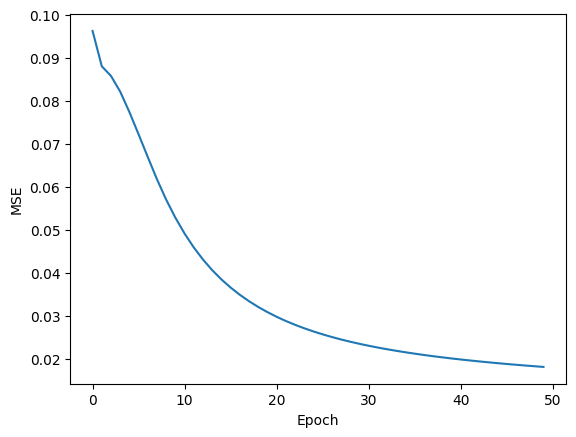

In [12]:
plt.plot(range(len(loss_hist)), loss_hist)
plt.ylabel('MSE')
plt.xlabel('Epoch')

plt.show()

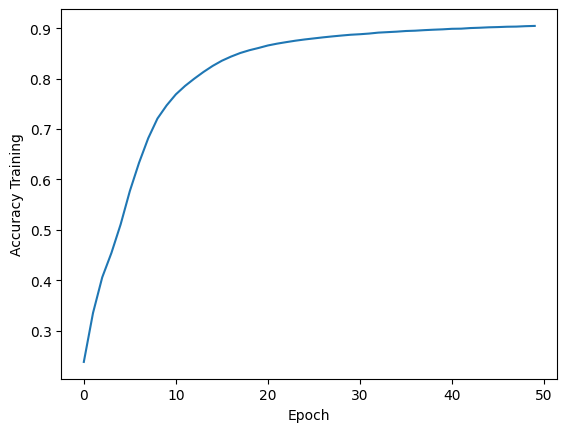

In [13]:
plt.plot(range(len(accuracy_hist)), accuracy_hist)
plt.ylabel('Accuracy Training')
plt.xlabel('Epoch')

plt.show()

In [14]:
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test) 

pred_test = model(X_test)

correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()

print(f'Test Acc.: {accuracy:.4f}')

Test Acc.: 0.9048


Działa gorzej od modelu w lab 3 zaimplementownego od podstaw?

## Następnie rozważyć różne modyfikacje tej sieci z wykorzystaniem możliwości, które daje moduł `torch.nn` (rozważyć inną liczbę i budowę warstw ukrytych, przetestować różne funkcje aktywacji oraz inne algorytmy optymalizacyjne z modułu `torch.optim`). Porównać otrzymane wyniki.

### Plan: Ustalony batch_size rowny 100, liczba epok rowna 50 i learning rate rowny 0.1. Testuje dobory reszty hiperparametrow wymienionych wyzej. Dla najlepszej dopasowac learning rate.

In [15]:
batch_size = 100
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

# Model 1 - zmiana liczby neuronow w warstwie ukrytej z 50 na 200

In [16]:
hidden_size = 200

model1 = Model(input_size, hidden_size, output_size)

learning_rate = 0.1

loss_fn = nn.MSELoss() 
 
optimizer = torch.optim.SGD(model1.parameters(), lr=learning_rate)

In [17]:
# Uczenie modelu (przez 50 epok):

num_epochs = 50
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs

for epoch in range(num_epochs):

    for x_batch, y_batch in train_dl:
        pred = model1(x_batch)  # Predykcja na x_batch

        y_one_hot_tensor = torch.zeros(len(y_batch), 10)
        y_one_hot_tensor[torch.arange(len(y_batch)), y_batch.long()] = 1      

        loss = loss_fn(pred, y_one_hot_tensor)  # Obliczanie funkcji straty między pred a y_batch
                                            
        loss.backward()  # Wsteczna propagacja błędów: oblicza gradienty funkcji straty
        optimizer.step()  # Aktualizuje parametry modelu przy użyciu obliczonych gradientów
        optimizer.zero_grad()  # Zeruje gradienty w optymalizatorze, aby były gotowe do następnej iteracji
    
        loss_hist[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()
        
    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)

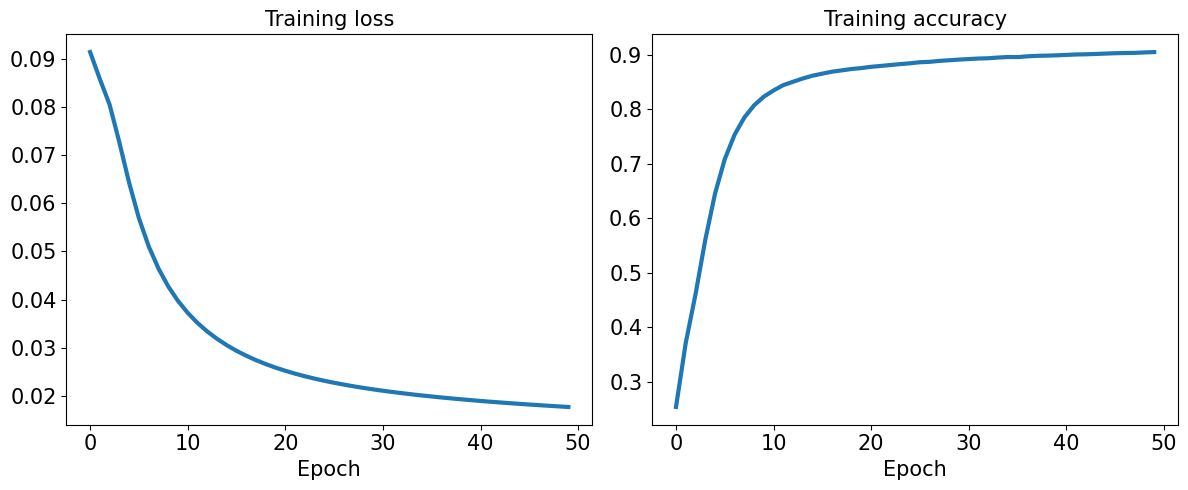

In [18]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_hist, lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_hist, lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()


plt.show()

In [19]:

pred_test1 = model1(X_test)

correct = (torch.argmax(pred_test1, dim=1) == y_test).float()
accuracy = correct.mean()

print(f'Test Acc.: {accuracy:.4f}')

Test Acc.: 0.9039


Wyniki w zasadzie identyczne, gorszy wynik na zbiorze testowym o 0.2 procenta

# Model 2 - zmiana fukncji aktywacji na ReLU

In [20]:
import torch.nn as nn


class Model2(nn.Module):

# W metodzie inicjalizacji określamy warstwy sieci:
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()  # Wywołanie konstruktora klasy bazowej nn.Module
                            # (super() jest używane do odwołania się do klasy bazowej)
        self.layer1 = nn.Linear(input_size, hidden_size)  
        self.layer2 = nn.Linear(hidden_size, output_size)  

# Metoda forward: definiujemy sposób, w jaki dane wejściowe x są przetwarzane przez model:
    def forward(self, x):
        x = self.layer1(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        return x
    
hidden_size = 50
output_size = 10

model2 = Model2(input_size, hidden_size, output_size)

learning_rate = 0.1

loss_fn = nn.MSELoss() 
 
optimizer = torch.optim.SGD(model2.parameters(), lr=learning_rate)


In [21]:
# Uczenie modelu (przez 50 epok):

num_epochs = 50
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs

for epoch in range(num_epochs):

    for x_batch, y_batch in train_dl:
        pred = model2(x_batch)  # Predykcja na x_batch

        y_one_hot_tensor = torch.zeros(len(y_batch), 10)
        y_one_hot_tensor[torch.arange(len(y_batch)), y_batch.long()] = 1      

        loss = loss_fn(pred, y_one_hot_tensor)  # Obliczanie funkcji straty między pred a y_batch
                                            
        loss.backward()  # Wsteczna propagacja błędów: oblicza gradienty funkcji straty
        optimizer.step()  # Aktualizuje parametry modelu przy użyciu obliczonych gradientów
        optimizer.zero_grad()  # Zeruje gradienty w optymalizatorze, aby były gotowe do następnej iteracji
    
        loss_hist[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()
        
    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)

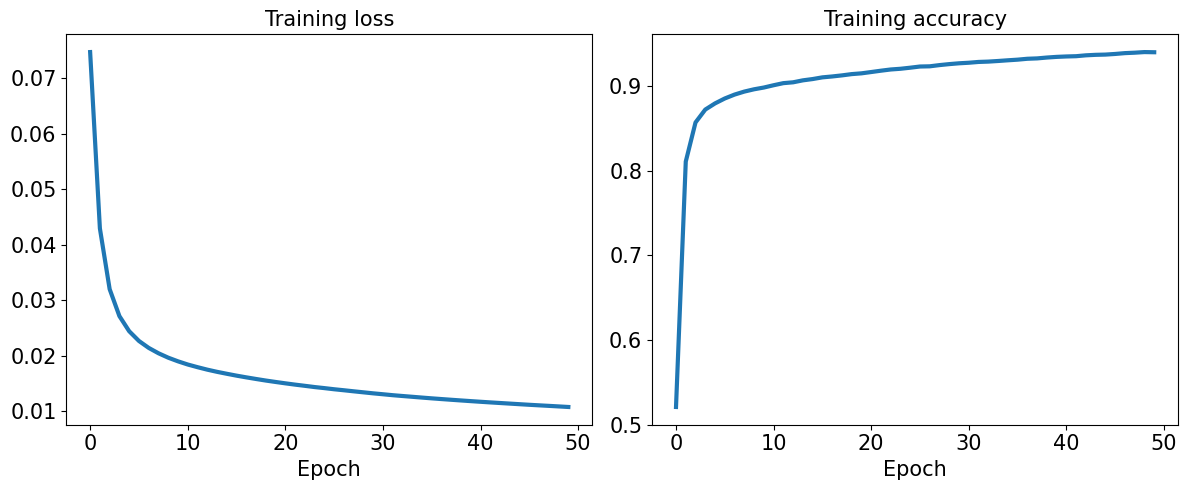

In [22]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_hist, lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_hist, lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()


plt.show()

In [23]:

pred_test2 = model2(X_test)

correct = (torch.argmax(pred_test2, dim=1) == y_test).float()
accuracy = correct.mean()

print(f'Test Acc.: {accuracy:.4f}')

Test Acc.: 0.9362


Tu juz lepiej wyglada, poprawa na treningowym i testowym (o 3 procent)

# Model 3 - zmiana algorytmu na averaged SGD

In [24]:
import torch.nn as nn


class Model3(nn.Module):

# W metodzie inicjalizacji określamy warstwy sieci:
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()  # Wywołanie konstruktora klasy bazowej nn.Module
                            # (super() jest używane do odwołania się do klasy bazowej)
        self.layer1 = nn.Linear(input_size, hidden_size)  
        self.layer2 = nn.Linear(hidden_size, output_size)  

# Metoda forward: definiujemy sposób, w jaki dane wejściowe x są przetwarzane przez model:
    def forward(self, x):
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        return x
    
hidden_size = 50
output_size = 10

model3 = Model3(input_size, hidden_size, output_size)

learning_rate = 0.1

loss_fn = nn.MSELoss() 
 
optimizer = torch.optim.ASGD(model3.parameters(), lr=learning_rate)


In [25]:
# Uczenie modelu (przez 50 epok):

num_epochs = 50
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs

for epoch in range(num_epochs):

    for x_batch, y_batch in train_dl:
        pred = model3(x_batch)  # Predykcja na x_batch

        y_one_hot_tensor = torch.zeros(len(y_batch), 10)
        y_one_hot_tensor[torch.arange(len(y_batch)), y_batch.long()] = 1      

        loss = loss_fn(pred, y_one_hot_tensor)  # Obliczanie funkcji straty między pred a y_batch
                                            
        loss.backward()  # Wsteczna propagacja błędów: oblicza gradienty funkcji straty
        optimizer.step()  # Aktualizuje parametry modelu przy użyciu obliczonych gradientów
        optimizer.zero_grad()  # Zeruje gradienty w optymalizatorze, aby były gotowe do następnej iteracji
    
        loss_hist[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()
        
    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)

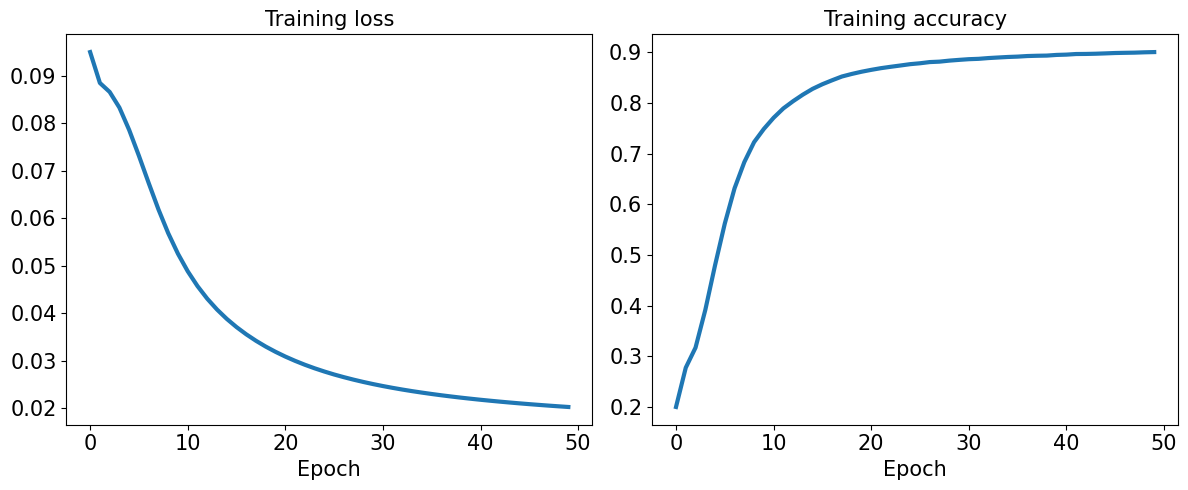

In [26]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_hist, lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_hist, lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()


plt.show()

In [27]:

pred_test3 = model3(X_test)

correct = (torch.argmax(pred_test3, dim=1) == y_test).float()
accuracy = correct.mean()

print(f'Test Acc.: {accuracy:.4f}')

Test Acc.: 0.9010


Gorzej wypada

# Model 4 - Zmiana funkcji aktywacji i algorytmu na Adadelta (losowy dobor)

In [28]:
class Model4(nn.Module):

# W metodzie inicjalizacji określamy warstwy sieci:
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()  # Wywołanie konstruktora klasy bazowej nn.Module
                            # (super() jest używane do odwołania się do klasy bazowej)
        self.layer1 = nn.Linear(input_size, hidden_size)  
        self.layer2 = nn.Linear(hidden_size, output_size)  

# Metoda forward: definiujemy sposób, w jaki dane wejściowe x są przetwarzane przez model:
    def forward(self, x):
        x = self.layer1(x)
        x = nn.Tanh()(x)
        x = self.layer2(x)
        x = nn.ReLU()(x)  
        return x
    
hidden_size = 50
output_size = 10

model4 = Model4(input_size, hidden_size, output_size)

learning_rate = 0.1

loss_fn = nn.MSELoss() 
 
optimizer = torch.optim.Adadelta(model4.parameters(), lr=learning_rate)  # Będzie wyjaśnione

In [29]:
# Uczenie modelu (przez 50 epok):

num_epochs = 50
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs

for epoch in range(num_epochs):

    for x_batch, y_batch in train_dl:
        pred = model3(x_batch)  # Predykcja na x_batch

        y_one_hot_tensor = torch.zeros(len(y_batch), 10)
        y_one_hot_tensor[torch.arange(len(y_batch)), y_batch.long()] = 1      

        loss = loss_fn(pred, y_one_hot_tensor)  # Obliczanie funkcji straty między pred a y_batch
                                            
        loss.backward()  # Wsteczna propagacja błędów: oblicza gradienty funkcji straty
        optimizer.step()  # Aktualizuje parametry modelu przy użyciu obliczonych gradientów
        optimizer.zero_grad()  # Zeruje gradienty w optymalizatorze, aby były gotowe do następnej iteracji
    
        loss_hist[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()
        
    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)

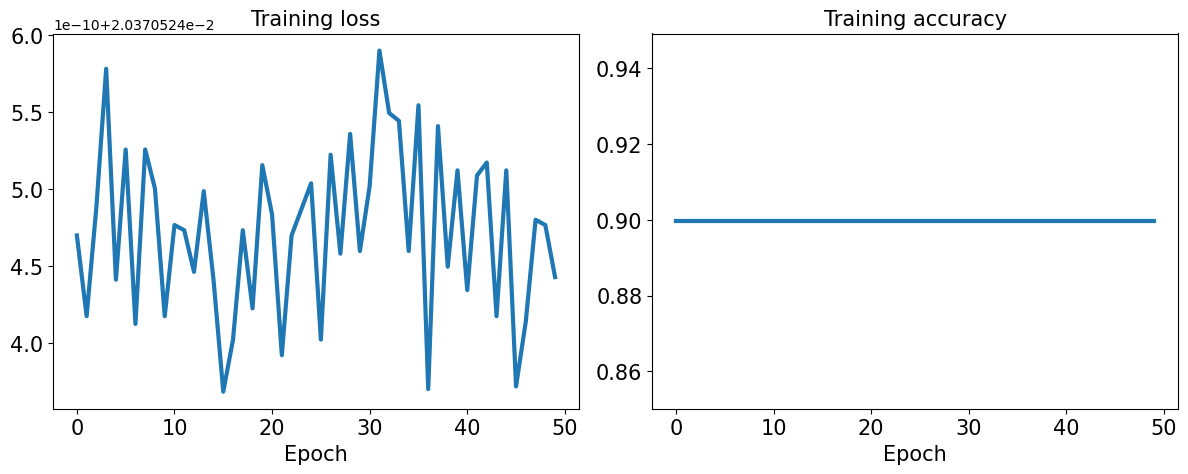

In [30]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_hist, lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_hist, lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()


plt.show()

In [31]:

pred_test4 = model4(X_test)

correct = (torch.argmax(pred_test4, dim=1) == y_test).float()
accuracy = correct.mean()

print(f'Test Acc.: {accuracy:.4f}')

Test Acc.: 0.0978


kompletnie losowy (slaby) wynik za tym idzie

## Zadanie 5.2*

Wykorzystując moduł `torch.nn`, zbudować od podstaw prostą sieć MLP dla dowolnie wybranego zadania klasyfikacji (np. na podstawie danych z biblioteki `torchvision.datasets` - patrz notebook z wykładu 4).

1. Dane
2. Dataset i Dataloader
3. infrastruktura modelu
4. Wybor funkcji straty i optymalizatora
5. Trenowanie modelu